# E-Commerce Conversion Funnel Analysis

**Objective:** Analyze user behavior data to identify conversion bottlenecks and provide actionable recommendations to improve purchase rates.

**Dataset:** E-commerce events from November 2019 (17.8M events)

**Author:** Jackson McBride
**Date:** January 2026

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

ecom_df = pd.read_csv('data/2019-Nov.csv')

print(f"✓ Data loaded successfully!")
print(f"Shape: {ecom_df.shape[0]:,} rows, {ecom_df.shape[1]} columns")

✓ Data loaded successfully!
Shape: 17,828,245 rows, 9 columns


## 1. Business Context

This analysis examines user behavior in an e-commerce store to understand:
- Where users drop off in the purchase funnel
- Which product categories perform best
- What behaviors indicate purchase intent

**Key Business Question:** Where should the company focus efforts to improve conversion rates?

## 2. Data Overview

In [2]:
ecom_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904.0,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790.0,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266.0,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591.0,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683.0,313628f1-68b8-460d-84f6-cec7a8796ef2


## 3. Funnel Analysis

Let's examine the basic conversion funnel: View → Cart → Purchase

In [3]:
event_counts = ecom_df['event_type'].value_counts()
print("Event Distribution:")
print(event_counts)
print(f"\nTotal events: {len(ecom_df):,}")

Event Distribution:
event_type
view        17198989
cart          381384
purchase      247872
Name: count, dtype: int64

Total events: 17,828,245


### 3.1 Funnel Visualization

The following chart shows the volume of users at each stage:


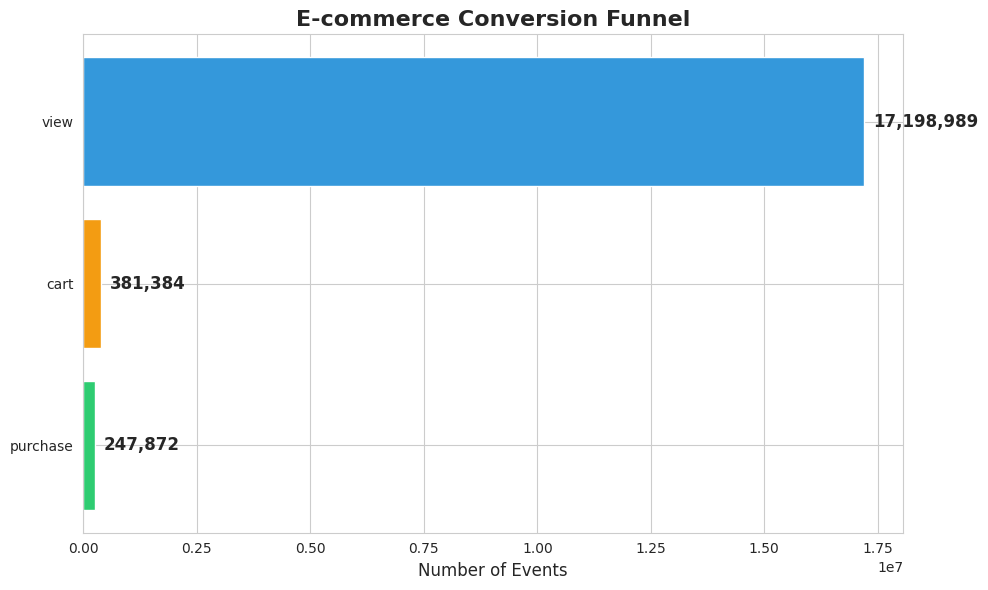

In [4]:
stages = ['view', 'cart', 'purchase']
counts = [
    ecom_df[ecom_df['event_type'] == 'view'].shape[0],
    ecom_df[ecom_df['event_type'] == 'cart'].shape[0],
    ecom_df[ecom_df['event_type'] == 'purchase'].shape[0]
]

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#3498db', '#f39c12', '#2ecc71']

bars =ax.barh(stages, counts, color=colors)

for i, (stage, count) in enumerate(zip(stages, counts)):
    ax.text(count + 200000, i, f'{count:,}', va='center', fontsize=12, fontweight='bold')

ax.set_xlabel('Number of Events', fontsize=12)
ax.set_title('E-commerce Conversion Funnel', fontsize=16, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

### 3.2 Conversion Rates

Here are the conversion rates between each stage:

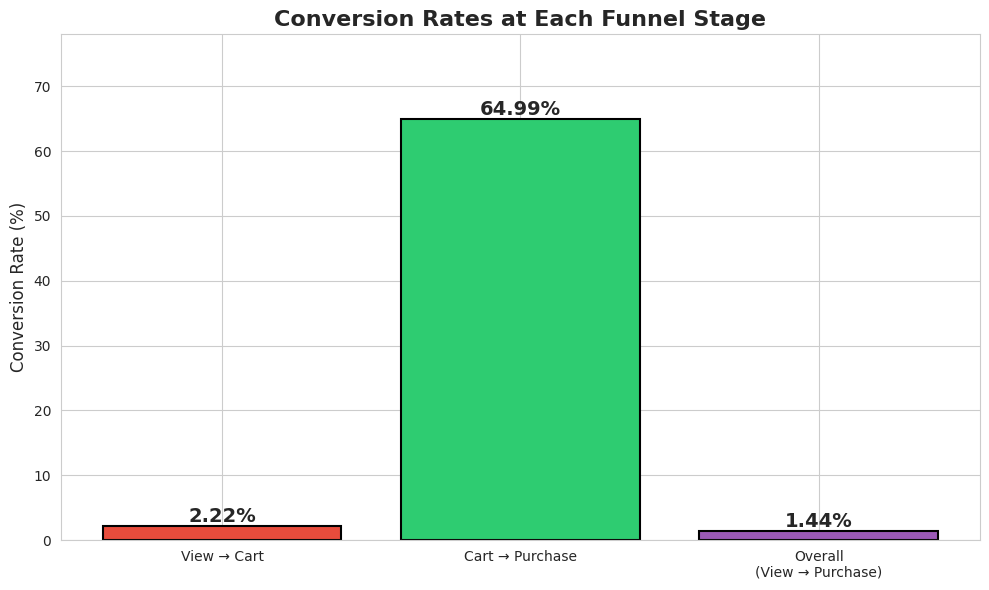

In [5]:
view_count = ecom_df[ecom_df['event_type'] == 'view'].shape[0]
cart_count = ecom_df[ecom_df['event_type'] == 'cart'].shape[0]
purchase_count = ecom_df[ecom_df['event_type'] == 'purchase'].shape[0]

view_to_cart = (cart_count / view_count) * 100
cart_to_purchase = (purchase_count / cart_count) * 100
overall = (purchase_count / view_count) * 100

fig, ax = plt.subplots(figsize=(10, 6))

conversions = ['View → Cart', 'Cart → Purchase', 'Overall\n(View → Purchase)']
rates = [view_to_cart, cart_to_purchase, overall]
colors = ['#e74c3c', '#2ecc71', '#9b59b6']

bars = ax.bar(conversions, rates, color=colors, edgecolor='black', linewidth=1.5)

for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Conversion Rate (%)', fontsize=12)
ax.set_title('Conversion Rates at Each Funnel Stage', fontsize=16, fontweight='bold')
ax.set_ylim(0, max(rates) * 1.2)

plt.tight_layout()
plt.show()

## 4. User Behavior Analysis

Do users who browse more actually convert better, or are they just window shopping?

In [6]:
user_activity = ecom_df.groupby('user_id').agg({
    'event_type': 'count',
    'product_id': 'nunique'
}).rename(columns={'event_type': 'total_events', 'product_id': 'unique_products'})

user_purchased = ecom_df[ecom_df['event_type'] == 'purchase']['user_id'].unique()
user_activity['purchased'] = user_activity.index.isin(user_purchased)

behavior_comparison = user_activity.groupby('purchased')[['total_events', 'unique_products']].mean()

print("Average Behavior: Purchasers vs Non-Purchasers")
print(behavior_comparison)

Average Behavior: Purchasers vs Non-Purchasers
           total_events  unique_products
purchased                               
False          9.205123         5.584731
True          24.419189         9.751152


### 4.1 Engagement Comparison

Purchasers engage significantly more before buying:

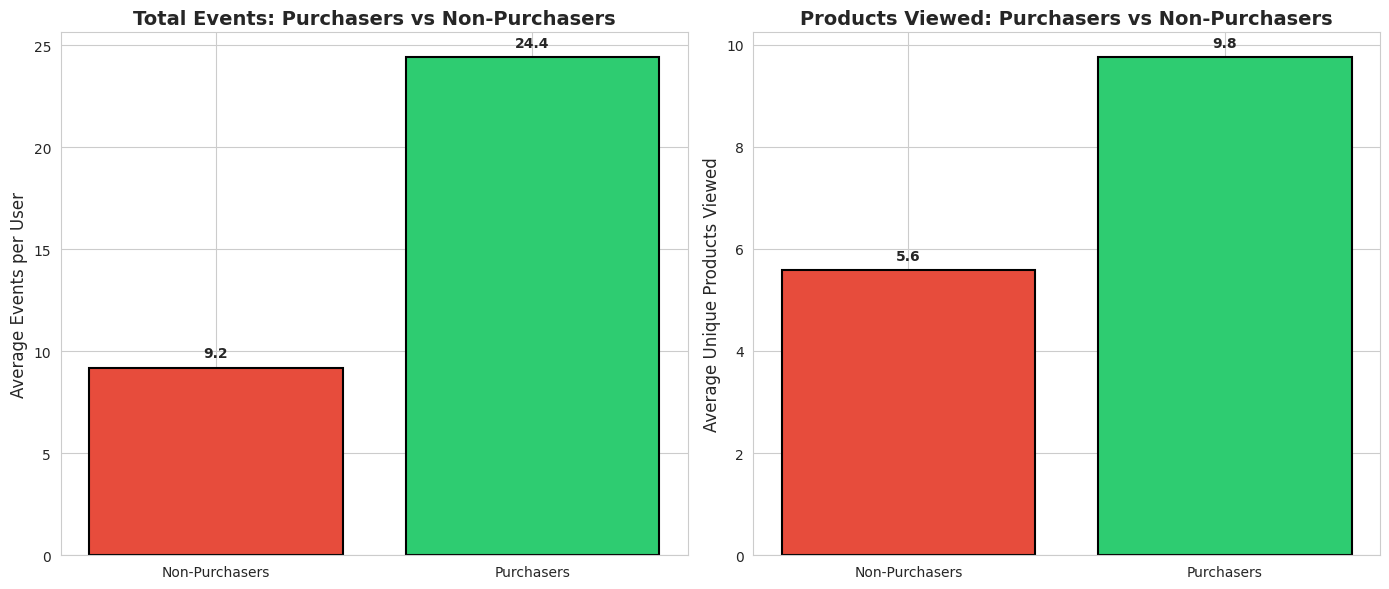

In [7]:
behavior_data = user_activity.groupby('purchased')[['total_events', 'unique_products']].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

categories = ['Non-Purchasers', 'Purchasers']
events = [behavior_data.loc[False, 'total_events'], behavior_data.loc[True, 'total_events']]
products = [behavior_data.loc[False, 'unique_products'], behavior_data.loc[True, 'unique_products']]

ax1.bar(categories, events, color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Average Events per User', fontsize=12)
ax1.set_title('Total Events: Purchasers vs Non-Purchasers', fontsize=14, fontweight='bold')
for i, v in enumerate(events):
    ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

ax2.bar(categories, products, color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Unique Products Viewed', fontsize=12)
ax2.set_title('Products Viewed: Purchasers vs Non-Purchasers', fontsize=14, fontweight='bold')
for i, v in enumerate(products):
    ax2.text(i, v + 0.2, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Category Performance

Which product categories convert best among high-traffic categories?

In [8]:
top_categories = ecom_df[ecom_df['event_type'] == 'view']['category_code'].value_counts().head(10).index

top_cat_data = ecom_df[ecom_df['category_code'].isin(top_categories)]

cat_conversion = top_cat_data.groupby(['category_code', 'event_type']).size().unstack(fill_value=0)
cat_conversion['conversion_rate'] = (cat_conversion['purchase'] / cat_conversion['view']) * 100

cat_conversion_sorted = cat_conversion.sort_values('conversion_rate', ascending=False)
print("Top 10 Categories - Conversion Rates:")
print(cat_conversion_sorted[['view', 'purchase', 'conversion_rate']])

Top 10 Categories - Conversion Rates:
event_type                           view  purchase  conversion_rate
category_code                                                       
electronics.smartphone            4216100    107247         2.543749
electronics.audio.headphone        418850     10088         2.408499
appliances.kitchen.washer          345018      5049         1.463402
electronics.video.tv               520655      7320         1.405921
electronics.clocks                 520074      5747         1.105035
appliances.environment.vacuum      341041      3632         1.064975
computers.notebook                 534286      4636         0.867700
appliances.kitchen.refrigerators   352438      2966         0.841566
computers.desktop                  189954       990         0.521179
apparel.shoes                      489083      2296         0.469450


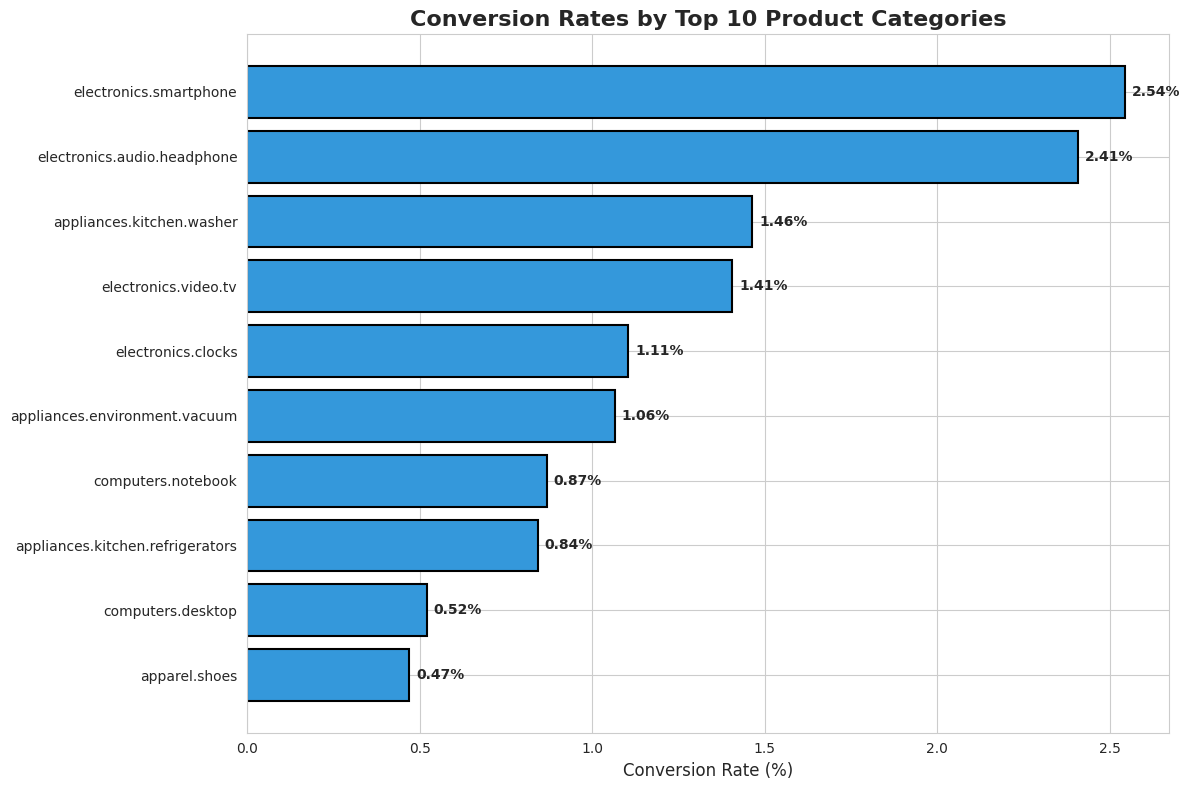

In [9]:
cat_viz = cat_conversion.sort_values('conversion_rate', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(cat_viz.index, cat_viz['conversion_rate'], 
               color='#3498db', edgecolor='black', linewidth=1.5)

for i, (idx, row) in enumerate(cat_viz.iterrows()):
    ax.text(row['conversion_rate'] + 0.02, i, f"{row['conversion_rate']:.2f}%", 
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Conversion Rate (%)', fontsize=12)
ax.set_title('Conversion Rates by Top 10 Product Categories', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Key Findings

Based on the analysis, here are the critical insights:

**1. Massive Drop-off at View → Cart Stage**
- Only 2.22% of viewers add items to cart
- However, 64.98% of users who add to cart complete purchase
- **Implication:** The checkout process is working well; the problem is getting users to engage initially

**2. Engaged Browsers Are Buyers**
- Purchasers view ~24 events vs ~9 for non-purchasers
- Purchasers browse ~10 unique products vs ~6 for non-purchasers
- **Implication:** More browsing indicates purchase intent, not indecision

**3. Category Performance Varies Significantly**
- Electronics (smartphones, headphones) show strongest conversion
- Desktop computers and shoes have lower conversion rates
- **Implication:** Category-specific strategies needed

## 7. Business Recommendations

Based on these findings, I recommend the following actions:

### Priority 1: Improve View → Cart Conversion
- **Implement product recommendations** to encourage exploration
- **Add "customers also bought" features** to surface related items
- **Simplify the add-to-cart process** with one-click options
- **Use exit-intent popups** with first-time purchase discounts

### Priority 2: Encourage Product Discovery
- **Don't rush users to checkout** - engaged browsers convert better
- **Improve search and filtering** to help users find relevant products
- **Create curated collections** and buying guides
- **Implement personalized recommendations** based on browsing behavior

### Priority 3: Category-Specific Optimization
- **Invest in high-converting categories** (smartphones, headphones)
- **Investigate underperforming categories** (desktops, shoes) - pricing? images? descriptions?
- **Cross-sell between categories** to increase basket size

### Estimated Impact
If we can improve View → Cart conversion from 2.22% to just 3%, with the current traffic volume, that represents approximately **133,000 additional cart adds per month**, which at current Cart → Purchase rates could yield **86,000+ additional purchases**.

## 8. Next Steps

To deepen this analysis, I would recommend:

1. **Cohort Analysis** - Track conversion rates over time to identify trends
2. **A/B Testing Framework** - Test recommended improvements (product recommendations, simplified cart flow)
3. **Customer Segmentation** - Analyze behavior by user demographics, device type, and traffic source
4. **Session Analysis** - Examine typical user journeys and identify common drop-off patterns
5. **Price Sensitivity Analysis** - Test whether discounts or promotions improve conversion at the cart stage

---

**Technical Stack:** Python (Pandas, Matplotlib, Seaborn), Jupyter Notebook  
**Dataset:** 17.8M e-commerce events from November 2019  
**GitHub Repository:** [Link to be added]